In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
from matplotlib import rc
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap,Normalize
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cmweather
import cmocean
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import glob
import os

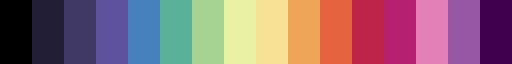

In [2]:
# Load colormap

# Read the colormap from a .txt file
def load_colormap_from_txt(file_path):
    # Load RGB values from the file
    rgb_values = np.loadtxt(file_path)
    return ListedColormap(rgb_values)

# Example usage
colormap_file = 'chase-spectral-rgb.txt'  # Replace with your .txt file path
radar_cmap = load_colormap_from_txt(colormap_file)

discrete_cmap = ListedColormap(radar_cmap(np.linspace(0, 1, 16)))
discrete_mask_cmap = discrete_cmap.copy()
discrete_mask_cmap.set_under(color='white') #set values below vmin to white
discrete_mask_cmap.set_bad(color='gray') #set missing (NaN) values to gray

discrete_mask_cmap

In [3]:
def dim_colormap(cmap_name='viridis', dim_factor=0.6, sat_factor=0.8, N=256):
    base = plt.get_cmap(cmap_name, N)
    colors = base(np.linspace(0, 1, N))
    # Convert to HSV
    hsv = mcolors.rgb_to_hsv(colors[:, :3])
    hsv[:, 1] *= sat_factor  # reduce saturation
    hsv[:, 2] *= dim_factor  # reduce brightness
    # Clip to valid range
    hsv = np.clip(hsv, 0, 1)
    # Convert back to RGB
    rgb = mcolors.hsv_to_rgb(hsv)
    # Re-attach alpha if present
    if colors.shape[1] == 4:
        rgb = np.concatenate([rgb, colors[:, 3:4]], axis=1)
    return mcolors.ListedColormap(rgb)

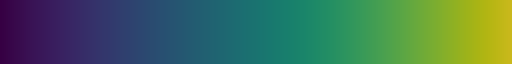

In [4]:
dimmer_viridis = dim_colormap('viridis', dim_factor=0.8, sat_factor=1)
dimmer_viridis

# Read in ship track data

In [5]:
#Open ship data
#CID: QmSSrT1UdtocfQS5yWSHFEJwJjqcNXjq2F1QfvNgLuEqSN
DSHIP= xr.open_dataset('ipns://latest.orcestra-campaign.org/products/METEOR/DShip.zarr',engine='zarr')

# Read in SEA-POL data

In [7]:
seapol = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4v1.1/PICCOLO_level4_rainrate_2D.nc')

In [8]:
# Mask out missing data (-32769 = no data possible)
rainrate = seapol.RAINRATE
dbz = seapol.DBZ

In [9]:

# Change -9999 missing data to zeros (data possible but removed = "not raining" though technically could be below beam) 
rainrate2 = rainrate.where(rainrate != -9999., 0)
#dbz2 = dbz
dbz2 = dbz.where(rainrate != -9999., np.nan)

In [10]:
# Also mask out seemingly bad data (rainrate > 1000 mm/h) or > 300 mm/h --> set to zero (like saying there is no echo)
rainrate3 = rainrate2.where((rainrate2 <= 1000) | (rainrate2.isnull()), 0) # keep nans
dbz3 = dbz2.where((rainrate2 <= 1000) | (dbz2.isnull()), np.nan)
rainrate4 = rainrate3.where((rainrate3 <= 300) | (rainrate3.isnull()), 0)
dbz4 = dbz3.where((rainrate3 <= 300) | (dbz3.isnull()), np.nan)

# Read in SST data

In [11]:
# Load data
file_paths = glob.glob("/huracan/tank4/cornell/ORCESTRA/oisstv2/202408/*.nc")
sst1 = xr.open_mfdataset(file_paths, combine='by_coords')

file_paths = glob.glob("/huracan/tank4/cornell/ORCESTRA/oisstv2/202409/*.nc")
sst2 = xr.open_mfdataset(file_paths, combine='by_coords')
sst = xr.concat([sst1, sst2], dim='time')
sst


<xarray.Dataset> Size: 697MB
Dimensions:  (time: 42, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 336B 2024-08-15T12:00:00 ... 2024-09-25T12...
  * zlev     (zlev) float32 4B 0.0
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    sst      (time, zlev, lat, lon) float32 174MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    anom     (time, zlev, lat, lon) float32 174MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 174MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 174MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/37)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    id:                         oisst-avhrr-v02r01.20240815.nc
    naming_authority:           gov.noaa.ncei
    ...                         ...
    time_coverage_start:        2024-08-15T00:00:00Z
    time_coverage_end:          2024-08-15T23:59:59Z
    metadata_link:              https://doi.org/10.25921/RE9P-PT57
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR

In [12]:
# restrict to 08-16 to 09-24 and to region of interest
sst = sst.sel(time=slice('2024-08-16', '2024-09-24'))
sst = sst.sel(lon=slice(360-66, 360-19), lat=slice(2, 19))

# average over time
sst_mean = sst.mean(dim='time')
sst_mean


<xarray.Dataset> Size: 206kB
Dimensions:  (zlev: 1, lat: 68, lon: 188)
Coordinates:
  * zlev     (zlev) float32 4B 0.0
  * lat      (lat) float32 272B 2.125 2.375 2.625 2.875 ... 18.38 18.62 18.88
  * lon      (lon) float32 752B 294.1 294.4 294.6 294.9 ... 340.4 340.6 340.9
Data variables:
    sst      (zlev, lat, lon) float32 51kB dask.array<chunksize=(1, 68, 188), meta=np.ndarray>
    anom     (zlev, lat, lon) float32 51kB dask.array<chunksize=(1, 68, 188), meta=np.ndarray>
    err      (zlev, lat, lon) float32 51kB dask.array<chunksize=(1, 68, 188), meta=np.ndarray>
    ice      (zlev, lat, lon) float32 51kB dask.array<chunksize=(1, 68, 188), meta=np.ndarray>

In [13]:
np.nanmin(sst_mean.sst.values), np.nanmax(sst_mean.sst.values)

(np.float32(26.122747), np.float32(30.93475))

# Make Plot

In [18]:
time_6h = pd.date_range(np.datetime64('2024-08-16T08:00:00'), np.datetime64('2024-09-23T16:50:00'), freq='6 h')
time_6h= pd.to_datetime(time_6h)
time_6h

DatetimeIndex(['2024-08-16 08:00:00', '2024-08-16 14:00:00',
               '2024-08-16 20:00:00', '2024-08-17 02:00:00',
               '2024-08-17 08:00:00', '2024-08-17 14:00:00',
               '2024-08-17 20:00:00', '2024-08-18 02:00:00',
               '2024-08-18 08:00:00', '2024-08-18 14:00:00',
               ...
               '2024-09-21 08:00:00', '2024-09-21 14:00:00',
               '2024-09-21 20:00:00', '2024-09-22 02:00:00',
               '2024-09-22 08:00:00', '2024-09-22 14:00:00',
               '2024-09-22 20:00:00', '2024-09-23 02:00:00',
               '2024-09-23 08:00:00', '2024-09-23 14:00:00'],
              dtype='datetime64[ns]', length=154, freq='6h')

In [19]:
#Re-index dbz to the 6h time grid
dbz_6h = dbz4.reindex(time=time_6h)
lat_6h = seapol.latitude.reindex(time=time_6h)
lon_6h = seapol.longitude.reindex(time=time_6h)

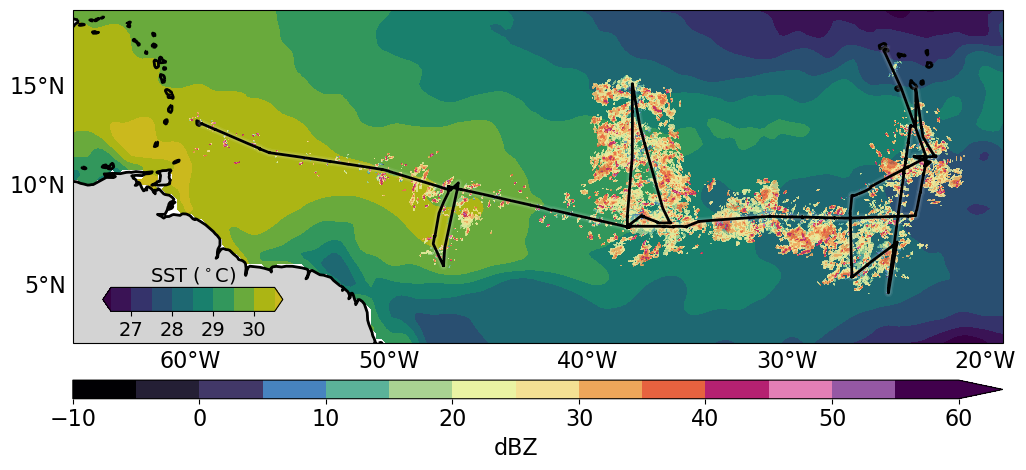

In [21]:
fig, ax = plt.subplots(figsize=(12,6),subplot_kw={'projection': ccrs.PlateCarree()})

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=0,alpha = 0.25)
ax.coastlines(resolution = '50m',alpha=1.0,linewidth=2)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10, 0, 10])
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

# Plot SST
im1 = ax.contourf(sst_mean.lon, sst_mean.lat, sst_mean.sst[0,:,:], vmin=26.5, vmax=30.5, levels=np.linspace(26.5,30.5,9), cmap=dimmer_viridis,extend='both')
#cbar = plt.colorbar(im1, ax=ax, orientation='vertical',pad=0.04, shrink=0.6)
#cbar.ax.tick_params(labelsize=16)
#cbar.set_label(r'SST ($^\circ$C)', fontsize=16)

# Plot ship track with a glowing effect
for glow_width, glow_alpha in zip([2, 4, 6], [0.2, 0.12, 0.07]):
    ax.plot(DSHIP.lon, DSHIP.lat, color='white', linewidth=glow_width, alpha=glow_alpha, zorder=10)
# Main line on top
ax.plot(DSHIP.lon, DSHIP.lat, color='black', linewidth=2, zorder=11)

#New way with re-indexed data
im = ax.contourf(lon_6h[0,:,:], lat_6h[0,:,:],dbz_6h[0,:,:],vmin=-10, vmax=60, levels = np.linspace(-10,60,15), cmap=discrete_mask_cmap, extend = 'max')
for n in range(1, len(time_6h)-1):
    ax.contourf(lon_6h[n,:,:], lat_6h[n,:,:],dbz_6h[n,:,:],vmin=-10, vmax=60, levels = np.linspace(-10,60,15), cmap=discrete_mask_cmap,alpha=0.75)
# Plot last time step
ax.contourf(lon_6h[-1,:,:], lat_6h[-1,:,:],dbz_6h[-1,:,:],vmin=-10, vmax=60, levels = np.linspace(-10,60,15), cmap=discrete_mask_cmap,alpha=0.75)

## Plot reflectivity mosaic
#im = ax.contourf(seapol.longitude[61,:,:], seapol.latitude[61,:,:],dbz4[61,:,:],vmin=-10, vmax=60, levels = np.linspace(-10,60,15), cmap=discrete_mask_cmap, extend = 'max')
##plt.plot(seapol.longitude[61,245,245], seapol.latitude[61,245,245], 'ko', markersize=1)
#interval = 36 #interval of time steps to plot (72 -> 12 hours)
#for n in range(0, 127):
#    ax.contourf(seapol.longitude[61+interval*n,:,:], seapol.latitude[61+interval*n,:,:],dbz4[61+interval*n,:,:],vmin=-10, vmax=60, levels = np.linspace(-10,60,15), cmap=discrete_mask_cmap,alpha=0.75)
#    #plt.plot(seapol.longitude[61+interval*n,245,245], seapol.latitude[61+interval*n,245,245], 'ko', markersize=1)
#ax.contourf(seapol.longitude[-1,:,:], seapol.latitude[-1,:,:],dbz4[-1,:,:],vmin=-10, vmax=60, levels = np.linspace(-10,60,15), cmap=discrete_mask_cmap,alpha=0.75)
##plt.plot(seapol.longitude[-1,245,245], seapol.latitude[-1,245,245], 'ko', markersize=1)

# Plot ship track
#plt.plot(DSHIP.lon, DSHIP.lat, 'k-', linewidth=2)

#add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal',pad=0.08,aspect=50)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('dBZ', fontsize=16)
ax.coastlines()

cbar_ax = fig.add_axes([0.15, 0.34, 0.15, 0.04])  # [left, bottom, width, height] in figure fraction
cbar = plt.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.set_ticks_position('bottom')
cbar.set_label(r'SST ($^\circ$C)',fontsize=14)  #add a label to the colorbar
cbar.set_ticks(np.linspace(27,30,4))
cbar.set_ticklabels([f'{x:2.0f}' for x in np.linspace(27,30,4)],fontsize=14)

#plt.title('Mosaic of SEA-POL long-range scans every 6 hours', fontsize=16)

## Save plot
plt.savefig('../../figures/Fig_seapol_mosaic_SST.png', bbox_inches='tight', dpi=300)